In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips_gpu, psnr

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc2_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

# get val loader
batch_size = 16
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


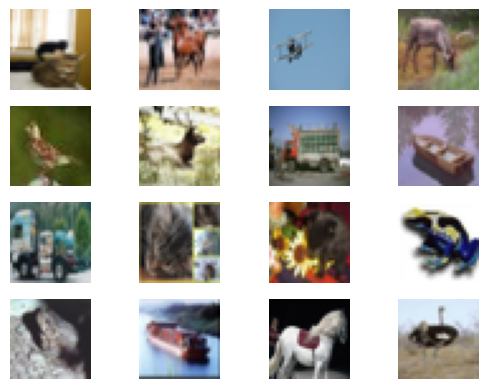

In [18]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [4]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 3072]), torch.Size([10, 256])]


In [5]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.2878201007843018
loss: 1.0064233541488647
loss: 1.0001784563064575
loss: 1.0001600980758667
loss: 1.0001665353775024
loss: 1.0001685619354248
loss: 1.0001767873764038
loss: 1.0001699924468994
loss: 1.0001654624938965
loss: 1.0001806020736694
loss: 1.0001702308654785
loss: 1.0001822710037231
loss: 1.0001754760742188
loss: 1.0001815557479858
loss: 1.000166893005371
loss: 1.0001829862594604
loss: 1.0001734495162964
loss: 1.0001789331436157
loss: 1.0001704692840576
loss: 1.0001697540283203
loss: 1.0001716613769531
loss: 1.0001678466796875
loss: 1.000162959098816
loss: 1.0001704692840576
loss: 1.0001718997955322
loss: 1.0001837015151978


In [7]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [8]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [9]:
psnr_match

[tensor([12,  6]),
 tensor([13,  3]),
 tensor([4, 1]),
 tensor([1, 7]),
 tensor([14,  9]),
 tensor([15,  8]),
 tensor([10,  2]),
 tensor([7, 5]),
 tensor([11, 13]),
 tensor([ 6, 15]),
 tensor([ 9, 12]),
 tensor([ 3, 10]),
 tensor([8, 0]),
 tensor([2, 4]),
 tensor([ 0, 14]),
 tensor([ 5, 11])]

In [10]:
mean_psnr

10.149516940116882

In [11]:
psnr_is_positive

[True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True]

## LPIPS

In [12]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips_gpu(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [13]:
lpips_match

[tensor([12,  8]),
 tensor([15,  3]),
 tensor([0, 6]),
 tensor([14,  7]),
 tensor([3, 9]),
 tensor([8, 1]),
 tensor([ 7, 13]),
 tensor([10,  5]),
 tensor([ 5, 10]),
 tensor([11, 11]),
 tensor([2, 0]),
 tensor([13, 15]),
 tensor([4, 2]),
 tensor([9, 4]),
 tensor([ 1, 14]),
 tensor([ 6, 12])]

In [21]:
mean_lpips

0.25930566899478436

In [15]:
lpips_is_positive

[True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False]

## Estimated images

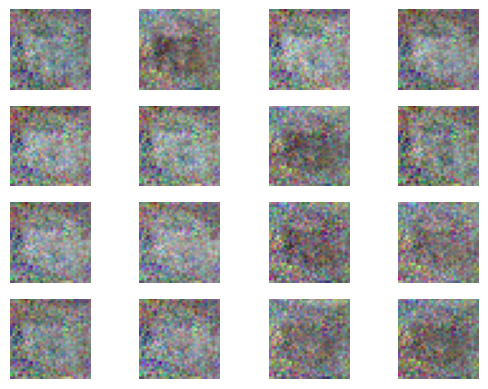

In [19]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(4, 4)
    
    for estimate_idx, (match, ax) in enumerate(zip(lpips_match, axes.flatten())):
        estimate = estimated_img[match[0].item()]
        estimate_coeff = 1 if lpips_is_positive[lpips_match[estimate_idx][0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

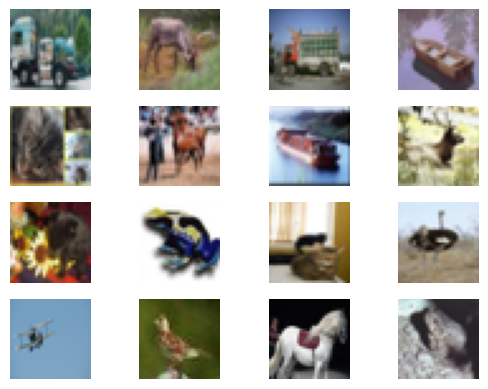

In [20]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for match, ax in zip(lpips_match, axes.flatten()):
        estimate = selected_val_batch_data[match[1].item()]
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()